# Ataque de adversario

En este cuaderno, voy a intentar realizar un ataque de adversario sobre una red neuronal construida utilizando Keras/Tensorwlow.

Un ataque de adversario consiste en conseguir una imagen que, sin parecer manipulada, una red neuronal la clasifica erróneamente. Con esto, se podría llegar a provocar que, por ejemplo, un coche autónomo al ver una señal de STOP la identifique como una señal de aumento de velocidad, provocando una situación peligrosa.

## Evaluación de la imagen

En primer lugar, voy a realizar una evaluación normal de una imagen de un coche. Para ello, primero importamos las librerías que necesitamos.

In [119]:
import tensorflow as tf # Importamos la librería de Tensorflow
import keras # Importamos Keras que trabaja sobre Tensor facilitándonos el trabajo
import matplotlib.pyplot as plt # Importamos Matplotlib para poder mostrar gráficas
import numpy as np # Importamos la librería Numpy para trabajar con matrices

Ahora, vamos a cargar nuestro modelo precargado utilizando Keras.

In [120]:
# Importamos los modelos entrenados de Keras, en especial la InceptionV3, de Google y para imágenes, así como, 
# decode_predictions que nos servirá luego para saber que respuesta nos ha dado la red neuronal
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K
from keras.preprocessing import image # Para trabajar con procesado de imágenes

A continuación, vamos a cargar el modelo de la librería.

In [121]:
iv3 = InceptionV3()

Tras ello, vamos a ver un resumen de este modelo, y ver todas las capas que tiene:

In [8]:
print(iv3.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

Finalmente, vamos a utilizar la imagen para probar nuestro modelo, en este caso, será la imagen de un coche.

In [106]:
# Cargamos la imagen en una variable como array con un tamaño redimensionado a 299x299
X = image.img_to_array(image.load_img("./coche.png", target_size=(299,299))) 

# InceptionV3 utiliza un formato diferente, el rango de intensidades va de -1 a 1. Vamos a reescalar este rango.
# Pasamos de [0,256) -> [-1,1]

X /= 255 
X -= 0.5 
X *= 2 

La red neuronal nos pide que pasemos un formato especial, un tensor, que tiene unas dimensiones parecidas
a las que tenemos ahora, pero necesitamos una dimensión más:

In [107]:
X = X.reshape([1, X.shape[0], X.shape[1], X.shape[2]])

Ahora, vamos a predecir qué tenemos en la imagen:

In [108]:
y = iv3.predict(X)

Pero, vamos a ver qué ha predicho:

In [109]:
decode_predictions(y)

[[('n04285008', 'sports_car', 0.76075476),
  ('n03459775', 'grille', 0.079246424),
  ('n03100240', 'convertible', 0.046836168),
  ('n04037443', 'racer', 0.0211682),
  ('n02974003', 'car_wheel', 0.01438693)]]

La imagen que le hemos pasado es la siguiente:

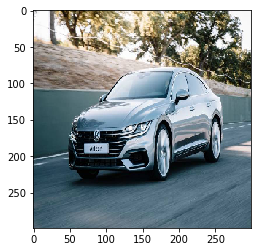

In [111]:
# Vamos a reescalar primero el rango de intensidades a como estaba originalmente
X1 = np.copy(X)

X1 /= 2
X1 += 0.5
X1 *= 255

plt.imshow(X1[0].astype(np.uint8))
plt.show()

## Generando la imagen para realizar el ataque de adversario

Ahora vamos a generar la nueva imagen, la que provocará que la red neuronal se equivoque. Esto es, ir provocando que se maximice el error:

In [112]:
input_layer = iv3.layers[0].input
output_layer = iv3.layers[-1].output

# Vamos a hacer creer a la red que queremos que lo clasifique como un limón (número 951)
target_class = 951

# Creamos una función de coste para que la última capa el resultado que muestre sea 'target_class'
loss = output_layer[0, target_class]

Ahora vamos a realizar el gradiente, para encontrar el mínimo, es decir, el objetivo:

In [116]:
# Nos hace el gráfo entre el valor de entrada y el cálculo del gradiente
grad = K.gradients(loss, input_layer)[0]

# Función que nos hace el cálculo del gradiente
optimize_gradient = K.function([input_layer, K.learning_phase], [grad, loss])

Una vez tenemos esto, hacemos el bucle donde ejecutar este código:

In [118]:
adv = np.copy(X)

cost = 0.0

while cost < 0.95:
    gr, cost = optimize_gradient([adv, 0]) # Utilizamos la copia que realizamos anteriormente
    adv += gr # Manipulamos los píxeles
    print("Target cost:", cost )

TypeError: Cannot interpret feed_dict key as Tensor: Can not convert a function into a Tensor.